In [2]:
import sys
import json
import cobra
import cplex
import re
import logging
from configparser import ConfigParser
config = ConfigParser()
config.read("config.cfg")
# paths = config.get("script", "syspaths").split(";")
# for path in paths:
#     sys.path.append(path)
import cobrakbase
from escher import Builder
from optlang.symbolics import Zero, add

#Put the path to ModelSEEDpy on your machine here
sys.path.append("/Users/ffoflonker/Documents/Command_line/ModelSEEDpy-main")
from modelseedpy import MSPackageManager, MSExpression

from modelseedpy import MSPackageManager, MSExpression
from sklearn.metrics import r2_score
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd



cobrakbase 0.2.7


In [6]:
#Uncomment the tissue datastructure for the model you want to run
#Single tissue model:
tissues = ["Mature_leaf"]
#Two tissue model:
#tissues = ["Mature_leaf","GermEmbryo_2_DAI"]
#16 tissue model:
#tissues = ["Mature_leaf","Zone_1","Zone_2","Zone_3","GermEmbryo_2_DAI","Pericarp_Aleurone_27_DAP","Endosperm_Crown_27_DAP","Endosperm_12_DAP","Endosperm_10_DAP","Endosperm_8_DAP","Embryo_38_DAP","Embryo_20_DAP","root_Stele","root_Cortex","root_EZ","root_MZ"]
# kbase_api = cobrakbase.KBaseAPI()
# model = kbase_api.get_from_ws("Modified_Athaliana_Model",25427)
model =cobra.io.read_sbml_model("Modified_Athaliana_Modelv3.xml")
model.solver = 'optlang-cplex'
#Setting model to complete media
#media = kbase_api.get_from_ws("Carbon-D-Glucose","KBaseMedia")
pkgmgr = MSPackageManager.get_pkg_mgr(model,1)
pkgmgr.getpkg("KBaseMediaPkg",1).build_package(None)

#Reading reaction protein abundances
#genome = kbase_api.get_from_ws("Zmays_Ensembl-18_2010-01-MaizeSequence",16026)
#proteome = MSExpression.from_gene_feature_file("ProteomeRawData.tsv",None,False)

#Reading reaction kcat values
data = ""
with open('KCats_grouped.txt', 'r') as file:
    data = file.read()
lines = data.split("\n")
reaction_kcat = {}
headers = None
for line in lines:
    if headers == None:
        headers = line.split("\t")
    else:
        array = line.split("\t")
        reaction_kcat[array[0]] = abs(float(array[1]))

#Reading measured reaction fluxes
data = ""
with open('Claudia_dv_Atha_v6.1.txt', 'r') as file:
    data = file.read()
lines = data.split("\n")
reaction_measures = {}
headers = None
for line in lines:
    if headers == None:
        headers = line.split("\t")
    else:
        array = line.split("\t")
        if array[1] not in reaction_measures:
                reaction_measures[array[1]] = dict()
        rxnid = array[0]
        reaction_measures[array[1]][rxnid] = abs(float(array[2]))

biomass_fluxes = {
    "root_MZ" : 0.049925,
    "root_EZ" : 0.049925,
    "root_Cortex" : 0.049925,
    "root_Stele" : 0.049925,
    "Embryo_20_DAP" : 0.015591667,
    "Embryo_38_DAP" : 0.015591667,
    "Endosperm_8_DAP" : 0.010208333,
    "Endosperm_10_DAP" : 0.010208333,
    "Endosperm_12_DAP" : 0.010208333,
    "Endosperm_Crown_27_DAP" : 0.010208333,
    "Pericarp_Aleurone_27_DAP" : 0.001529167,
    "GermEmbryo_2_DAI" : 0.015591667,
    "Zone_1" : 0.006395833,
    "Zone_2" : 0.006395833,
    "Zone_3" : 0.006395833,
    "Mature_leaf" : 0.006395833
}

protein_fraction = {
	'root_MZ': 0.05,
	'root_EZ' :0.05,
	'root_Cortex': 0.05,
	'root_Stele' : 0.05,
	'Embryo_20_DAP' : 0.116,
	'Embryo_38_DAP' : 0.116,
	'Endosperm_8_DAP' : 0.08,
	'Endosperm_10_DAP' : 0.08,
	'Endosperm_12_DAP' : 0.08,
	'Endosperm_Crown_27_DAP' : 0.08,
	'Pericarp_Aleurone_27_DAP' : 0.09,
	'GermEmbryo_2_DAI' : 0.116,
	'Zone_1': 0.0948,
	'Zone_2': 0.0948,
	'Zone_3': 0.0948,
	'Mature_leaf': 0.0948
}

modellist = []
count = 0
base_model = None
for tissue in tissues:
    print("Tissue:"+tissue)
    #Safe cloning method
    clone_model = cobra.io.json.from_json(cobra.io.json.to_json(model))
    #Applying flexible biomass constraints
    pkgmgr = MSPackageManager.get_pkg_mgr(clone_model,1)
    protein = protein_fraction[tissue]
    protein_flux = -1*(0.2-protein)
    pkgmgr.getpkg("FlexibleBiomassPkg",1).build_package({"bio_rxn_id":"bio1_biomass","use_rna_class":[-0.75,0.75],
        "use_dna_class":[-0.75,0.75],
        "use_protein_class":[protein_flux,protein_flux],
        "use_energy_class":[-0.1,0.1]})
    #Adding tissue specific proteome constraints
    package_params = {
        #"proteome":proteome,
        "condition":tissue,
        "flux_values":reaction_measures[tissue],
        "prot_coef" : protein_fraction[tissue],#Set to the fraction of the cell that is protein
        "totalflux" : 1,#Set to one if we're fitting flux magnitude rather than actual flux to flux measurements
        "kcat_coef" : 0.02,#kapp = kcat_coef * kcat
        "set_objective":0
    }
    #Only base model fits kcat values
    if count == 0:
        package_params["kcat_values"] = reaction_kcat
    pkgmgr.getpkg("FluxFittingPkg",1).build_package({
        "target_flux":reaction_measures[tissue],
        "totalflux":1,
        "set_objective":0,
        "default_rescaling":0.1,
        "rescale_vfit_by_flux":False
    })
    #pkgmgr.getpkg("ProteomeFittingPkg",1).build_package(package_params)
    #Constraining biomass flux to reference value
    rxn = clone_model.reactions.get_by_id("bio1_biomass")
    rxn.upper_bound = biomass_fluxes[tissue]
    rxn.lower_bound = biomass_fluxes[tissue]
    if count == 0:
        base_model = clone_model
    else:
        modellist.append(clone_model)
    count += 1

#Coefficient for kcat fitting:
kcat_fit = 1e-1
#Coefficient for flux fitting:
flux_fit = 1
#Coefficient for kinetic fitting:
kinetic_fit = 1e-6
#Pulling based model package manager
pkgmgr = MSPackageManager.get_pkg_mgr(base_model,1)
#Merging all models together
if count > 1:
    pkgmgr.getpkg("ProblemReplicationPkg",1).build_package({"models":modellist,"shared_variable_packages":{pkgmgr.getpkg("ProteomeFittingPkg"):["kapp"]}})
#Creating combined objective function
objvars = []
#Adding base model kfit,kvfit,and vfit to objective
for rxnid in pkgmgr.getpkg("FluxFittingPkg").variables["vfit"]:
    objvars.append(flux_fit * pkgmgr.getpkg("FluxFittingPkg").variables["vfit"][rxnid] ** 2)
#for rxnid in pkgmgr.getpkg("ProteomeFittingPkg").variables["kvfit"]: 
#    objvars.append(kinetic_fit * pkgmgr.getpkg("ProteomeFittingPkg").variables["kvfit"][rxnid] ** 2)
#for rxnid in pkgmgr.getpkg("ProteomeFittingPkg").variables["kfit"]: 
#    objvars.append(kcat_fit * pkgmgr.getpkg("ProteomeFittingPkg").variables["kfit"][rxnid] ** 2)
#Adding sub model kvfit,and vfit to objective
count = 0
for submodel in modellist:
    submgr = MSPackageManager.get_pkg_mgr(submodel)
    #for rxnid in submgr.getpkg("ProteomeFittingPkg").variables["kvfit"]:
    #    varname = submgr.getpkg("ProteomeFittingPkg").variables["kvfit"][rxnid].name
    #    objvars.append(kinetic_fit * pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count)][varname] ** 2)
    for rxnid in submgr.getpkg("FluxFittingPkg").variables["vfit"]:
        varname = submgr.getpkg("FluxFittingPkg").variables["vfit"][rxnid].name
        objvars.append(flux_fit * pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count)][varname] ** 2)
    count += 1
#Setting the objective
base_model.objective = base_model.problem.Objective(add(objvars), direction="min", sloppy=True)
base_model.optimize()

#Printing LP file
with open('ProteomeDrivenModeling.lp', 'w') as out:
    out.write(str(base_model.solver))

#Pulling solution data
solution_data = {}
count = 0
for tissue in tissues:
    solution_data[tissue] = {"flux":{},"vfit":{},"kfit":{},"kvfit":{},"kapp":{},"flex":{}}     
    if count == 0:
        for reaction in base_model.reactions:
            if re.search('FLEX_(cpd\d+_c0)', reaction.id) != None:
                m = re.search('FLEX_(cpd\d+_c0)', reaction.id)
                solution_data[tissue]["flex"][m[1]] = reaction.flux
            elif re.search('([a-z]+)_flex', reaction.id) != None:
                m = re.search('([a-z]+)_flex', reaction.id)
                solution_data[tissue]["flex"][m[1]] = reaction.flux
            else:
                solution_data[tissue]["flux"][reaction.id] = reaction.flux
        for rxnid in pkgmgr.getpkg("FluxFittingPkg").variables["vfit"]:
            solution_data[tissue]["vfit"][rxnid] = pkgmgr.getpkg("FluxFittingPkg").variables["vfit"][rxnid].primal
        #for rxnid in pkgmgr.getpkg("ProteomeFittingPkg").variables["kfit"]:
        #    solution_data[tissue]["kfit"][rxnid] = pkgmgr.getpkg("ProteomeFittingPkg").variables["kfit"][rxnid].primal
        #for rxnid in pkgmgr.getpkg("ProteomeFittingPkg").variables["kapp"]:
        #    solution_data[tissue]["kapp"][rxnid] = pkgmgr.getpkg("ProteomeFittingPkg").variables["kapp"][rxnid].primal
        #for rxnid in pkgmgr.getpkg("ProteomeFittingPkg").variables["kvfit"]:
        #    solution_data[tissue]["kvfit"][rxnid] = pkgmgr.getpkg("ProteomeFittingPkg").variables["kvfit"][rxnid].primal
    else:
        submodel = modellist[count-1]
        submgr = MSPackageManager.get_pkg_mgr(submodel)
        for reaction in base_model.reactions:
            if re.search('FLEX_(cpd\d+_c0)', reaction.id) != None:
                m = re.search('FLEX_(cpd\d+_c0)', reaction.id)
                solution_data[tissue]["flex"][m[1]] = pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count-1)][reaction.forward_variable.name].primal
                solution_data[tissue]["flex"][m[1]] += -1*pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count-1)][reaction.reverse_variable.name].primal
            elif re.search('([a-z]+)_flex', reaction.id) != None:
                m = re.search('([a-z]+)_flex', reaction.id)
                solution_data[tissue]["flex"][m[1]] = pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count-1)][reaction.forward_variable.name].primal
                solution_data[tissue]["flex"][m[1]] += -1*pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count-1)][reaction.reverse_variable.name].primal
            else:
                solution_data[tissue]["flux"][reaction.id] = pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count-1)][reaction.forward_variable.name].primal
                solution_data[tissue]["flux"][reaction.id] += -1*pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count-1)][reaction.reverse_variable.name].primal
        #for rxnid in submgr.getpkg("ProteomeFittingPkg").variables["kfit"]:
        #    varname = submgr.getpkg("ProteomeFittingPkg").variables["kfit"][rxnid].name
        #    solution_data[tissue]["kfit"][rxnid] = pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count-1)][varname].primal
        #for rxnid in submgr.getpkg("ProteomeFittingPkg").variables["kvfit"]:
        #    varname = submgr.getpkg("ProteomeFittingPkg").variables["kvfit"][rxnid].name
        #    solution_data[tissue]["kvfit"][rxnid] = pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count-1)][varname].primal
        for rxnid in submgr.getpkg("FluxFittingPkg").variables["vfit"]:
            varname = submgr.getpkg("FluxFittingPkg").variables["vfit"][rxnid].name
            solution_data[tissue]["vfit"][rxnid] = pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count-1)][varname].primal    
    count += 1

Tissue:Mature_leaf


In [7]:
col=[]
for rxn in model.reactions:
    col.append(rxn.id)
sol_df=pd.DataFrame(col)
sol_df.set_index(0,inplace=True)
sol_df

#print fluxes for all tissues
for tiss in tissues:
    df=pd.DataFrame.from_dict(solution_data[tiss])
    df.rename(columns={"flux": tiss}, inplace=True)
    df2=df[tiss]
    sol_df=sol_df.merge(df2, left_index=True, right_index=True)
sol_df.to_csv("Maize16tiss-results.csv", header=True)
sol_df

,Mature_leaf
rxn00001_c0,0.000000e+00
rxn00001_d0,0.000000e+00
rxn00001_g0,0.000000e+00
rxn00001_v0,0.000000e+00
rxn00001_w0,0.000000e+00
...,...
EX_cpd23756_e0,0.000000e+00
EX_cpd23719_e0,0.000000e+00
EX_cpd09188_e0,0.000000e+00
DM_cpd11416_c0,6.395833e-03


0.5927666477601083


Text(0.5, 1.0, 'Measured')

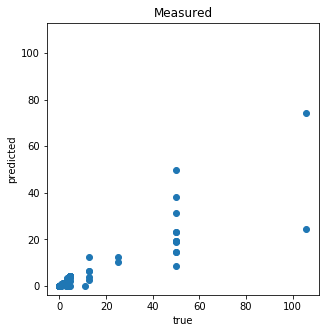

In [8]:
 ######## r2 measured
tissue="Mature_leaf"
y_pred=[]
y_true=[]
for rxn in reaction_measures[tissue].keys():
    if rxn in model.reactions:
        #if reaction_measures[tissue][rxn]<0.02:
        y_true.append(reaction_measures[tissue][rxn])
        y_pred.append(abs(solution_data[tissue]['flux'][rxn]))
r2_m=r2_score(y_true,y_pred)
print(r2_m)

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred)
plt.axis('square');
# plt.xlim(-.001,0.04)
# plt.ylim(-0.001,0.04)
plt.xlabel("true")
plt.ylabel("predicted")
plt.title("Measured")